<a href="https://colab.research.google.com/github/johanhoffman/DD2365_VT24/blob/ivan-private_lab2/Lab2/ivan-private_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Ivan Zivkovic**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://www.kth.se/social/course/DD2365/)

# **About the code**

In [27]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [28]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt
import matplotlib.animation as animation


from IPython.display import Image, Video, display, HTML

import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CFD_lab_2_results')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula:

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization,

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder).

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g.

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define domain and mesh**

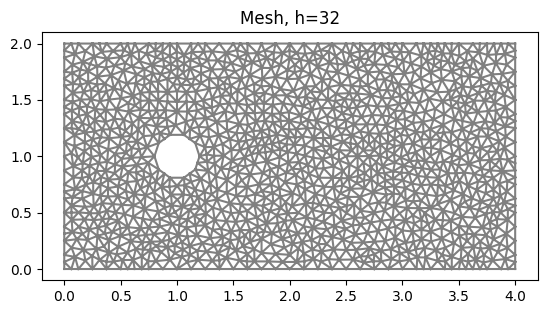

In [29]:
# Define rectangular domain
L = 4
H = 2

# Define circle
xc = 1.0
yc = 0.5*H
rc = 0.2

# Define subdomains (for boundary conditions)
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], L)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], H)

left = Left()
right = Right()
lower = Lower()
upper = Upper()

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
#mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(xc,yc),rc), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for cell in cells(mesh):
        cell_marker[cell] = False
        p = cell.midpoint()

        if p.distance(Point(xc, yc)) < 1.0:
            cell_marker[cell] = True

    mesh = refine(mesh, cell_marker)

# Define mesh functions (for boundary conditions)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundaries.set_all(0)
left.mark(boundaries, 1)
right.mark(boundaries, 2)
lower.mark(boundaries, 3)
upper.mark(boundaries, 4)


plt.figure()
plot(mesh, title=f"Mesh, h={resolution}")
plt.savefig(f"mesh, h={resolution}.png")
plt.show()


**Define finite element approximation spaces**

In [30]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0064528 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.251894 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00276399 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0125525 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

**Define boundary conditions**

In [31]:
# Define boundary conditions
class DirichletBoundaryLower(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.0)

class DirichletBoundaryUpper(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], H)

class DirichletBoundaryLeft(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], 0.0)

class DirichletBoundaryRight(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[0], L)

class DirichletBoundaryObjects(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

dbc_lower = DirichletBoundaryLower()
dbc_upper = DirichletBoundaryUpper()
dbc_left = DirichletBoundaryLeft()
dbc_right = DirichletBoundaryRight()
dbc_objects = DirichletBoundaryObjects()

# Examples of time dependent and stationary inflow conditions
#uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
#uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
uin = 1.0
bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
pout = 0.0
#bcp0 = DirichletBC(Q, pin, dbc_left)
bcp1 = DirichletBC(Q, pout, dbc_right)

#bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
bcp = [bcp1]

# Define measure for boundary integration
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

# **Results**

**Define flow parameters**

The Reynolds number is defined for this problem as
$$Re = \frac{UD}{\nu} $$

Where $U=1$ is the inflow velocity, $D=0.4$ is the diameter of the cylinder and $\nu$ is the viscosity.

This simulation will be run with with Reynolds number = 1, 10, 100 and 1000 and the results will be compared. To be able to set the Reynolds number in this simulation, the viscosity will be varied.

For this problem we have $Re = 0.4 / \nu \implies \nu = 0.4 / Re$. So, the different viscosities to obtain the different Reynolds numbers will be:

$Re = 1$
$$\nu_{1} = 0.4 / 1 = 4 * 10^{-1}$$

$Re = 10$
$$\nu_{10} = 0.4 / 10 = 4 * 10^{-2}$$

$Re = 100$
$$\nu_{100} = 0.4 / 100 = 4 * 10^{-3}$$

$Re = 1000$
$$\nu_{1000} = 0.4 / 1000 = 4 * 10^{-4}$$



In [32]:
# Set viscosity
#nu = 4.0e-4 # Re = 1000
nu = 4.0e-3 # Re = 100
#nu = 4.0e-2 # Re = 10
#nu = 4.0e-1 # Re = 1

reynolds_number = int(uin * 2 * rc / nu)

**Define method parameters**

In [33]:
# Define iteration functions
# (u0,p0) solution from previous time step
# (u1,p1) linearized solution at present time step
u0 = Function(V)
u1 = Function(V)
p0 = Function(Q)
p1 = Function(Q)

# Set parameters for nonlinear and lienar solvers
num_nnlin_iter = 5
prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

# Time step length
dt = 0.5*mesh.hmin()

**Define variational problem**

In [34]:
# Define variational problem

# Stabilization parameters
h = CellDiameter(mesh);
u_mag = sqrt(dot(u1,u1))
d1 = 1.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
d2 = h*u_mag

# Mean velocities for trapozoidal time stepping
um = 0.5*(u + u0)
um1 = 0.5*(u1 + u0)

# Momentum variational equation on residual form
Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx - p1*div(v)*dx + nu*inner(grad(um), grad(v))*dx \
    + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx + d2*div(um)*div(v)*dx
au = lhs(Fu)
Lu = rhs(Fu)

# Continuity variational equation on residual form
Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
ap = lhs(Fp)
Lp = rhs(Fp)

**Compute force on boundary**

In [35]:
# Define the direction of the force to be computed
phi_x, phi_y = (0.0, 1.0) #lift force



#psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

lift_force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx


# Define the direction of the force to be computed
phi_x, phi_y = (1.0, 0.0) #drag force
psi_expression = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x, phi_y=phi_y, element = V.ufl_element())
psi = interpolate(psi_expression, V)

drag_force = inner((u1 - u0)/dt + grad(um1)*um1, psi)*dx - p1*div(psi)*dx + nu*inner(grad(um1), grad(psi))*dx

# Force normalization
D = 2*rc
normalization = -2.0/D

**Set plotting variables and open export files**

In [36]:
# Open files to export solution to Paraview
#file_u = File(f"results-Re-{reynolds_number}/u.pvd")
#file_p = File(f"results-Re-{reynolds_number}/p.pvd")

# Set plot frequency
plot_time = 0
plot_freq = 10


# Force computation data
lift_force_array = np.array([])
drag_force_array = np.array([])

time = np.array(0.0)
time = np.delete(time, 0)
start_sample_time = 1.0

**Time stepping algorithm**

In [37]:
#!rm results-NS/*


#fig = plt.figure()


# Time stepping
T = 10
t = dt
while t < T + DOLFIN_EPS:

    pin.t = t

    # Solve non-linear problem
    k = 0
    while k < num_nnlin_iter:

        # Assemble momentum matrix and vector
        Au = assemble(au)
        bu = assemble(Lu)

        # Compute velocity solution
        [bc.apply(Au, bu) for bc in bcu]
        [bc.apply(u1.vector()) for bc in bcu]
        solve(Au, u1.vector(), bu, "bicgstab", "default")

        # Assemble continuity matrix and vector
        Ap = assemble(ap)
        bp = assemble(Lp)

        # Compute pressure solution
        [bc.apply(Ap, bp) for bc in bcp]
        [bc.apply(p1.vector()) for bc in bcp]
        solve(Ap, p1.vector(), bp, "bicgstab", prec)

        # Compute force
        F_d = assemble(drag_force)
        F_l = assemble(lift_force)
        if (t > start_sample_time):
            drag_force_array = np.append(drag_force_array, normalization * F_d)
            lift_force_array = np.append(lift_force_array, normalization * F_l)
            time = np.append(time, t)

        k += 1


    #print(f"Time: {t} of {T}")

    # Save solution to file
    #file_u << u1
    #file_p << p1


    # Update time step
    u0.assign(u1)
    t += dt


# Plot solution
"""
plt.figure()
plot(u1, title=f"Velocity, Re={reynolds_number}, h={resolution}")
plt.savefig(f"Velocity, Re={reynolds_number}, h={resolution}")
plt.show()

plt.figure()
plot(p1, title=f"Pressure, Re={reynolds_number}, h={resolution}")
plt.savefig(f"Pressure, Re={reynolds_number}, h={resolution}")
plt.show()


plt.figure()
plt.title(f"Drag force, Re={reynolds_number}, h={resolution}")
plt.xlabel("t")
plt.plot(time, drag_force_array)
plt.savefig(f"Drag force, Re={reynolds_number}, h={resolution}")
plt.show()

plt.figure()
plt.title(f"Lift force, Re={reynolds_number}, h={resolution}")
plt.xlabel("t")
plt.plot(time, lift_force_array)
plt.savefig(f"Lift force, Re={reynolds_number}, h={resolution}")
plt.show()
"""
#!tar -czvf results-NS.tar.gz results-NS
#files.download('results-NS.tar.gz')

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_9a2e6ba300e8e77918a9ad5b48e6ae34cc251f8f

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    2
  Coefficients:              '[f_207, f_210]'
  Unique elements:           'Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0546925 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_899f792bca9deb3c3f12f5cb62d42f0545d411ea

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00399661 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0156004 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_79dd4099c4e669212673d783637297ee756e6a33

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00605774 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0131445 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_66170f427fb7c9d9caadb39d728b0be317507df5

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00446773 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.00927329 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INF

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c5f2d4076211210d93a0f5a6dbb45672bc096862

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    3
  Coefficients:              '[f_207, f_210, f_216]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 10
INFO:FFC:  quadrature_degree: 10
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0414648 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_46b9e65fcb4b2fb5349cd2071e9b331e33eac0a7

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    1
  Coefficients:              '[f_210]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 8
INFO:FFC:  quadrature_degree: 8
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0236475 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_a13d0e7e30e9812ee35e12056888e5df899015d5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_207, f_210]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 9
INFO:FFC:  quadrature_degree: 9
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0340226 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_595219e2b6a71aa9a1e7ca1d4c5f29b88d415199

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    4
  Coefficients:              '[f_207, f_210, f_216, f_224]'
  Unique elements:           'Vector<2 x CG1(?,?)>, CG1(?,?)'
  Unique sub elements:       'Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0387115 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------

'\nplt.figure()\nplot(u1, title=f"Velocity, Re={reynolds_number}, h={resolution}")\nplt.savefig(f"Velocity, Re={reynolds_number}, h={resolution}")\nplt.show()\n\nplt.figure()\nplot(p1, title=f"Pressure, Re={reynolds_number}, h={resolution}")\nplt.savefig(f"Pressure, Re={reynolds_number}, h={resolution}")\nplt.show()\n\n\nplt.figure()\nplt.title(f"Drag force, Re={reynolds_number}, h={resolution}")\nplt.xlabel("t")\nplt.plot(time, drag_force_array)\nplt.savefig(f"Drag force, Re={reynolds_number}, h={resolution}")\nplt.show()\n\nplt.figure()\nplt.title(f"Lift force, Re={reynolds_number}, h={resolution}")\nplt.xlabel("t")\nplt.plot(time, lift_force_array)\nplt.savefig(f"Lift force, Re={reynolds_number}, h={resolution}")\nplt.show()\n'

<Figure size 640x480 with 0 Axes>

**Plot simulation results for different Reynolds numbers**

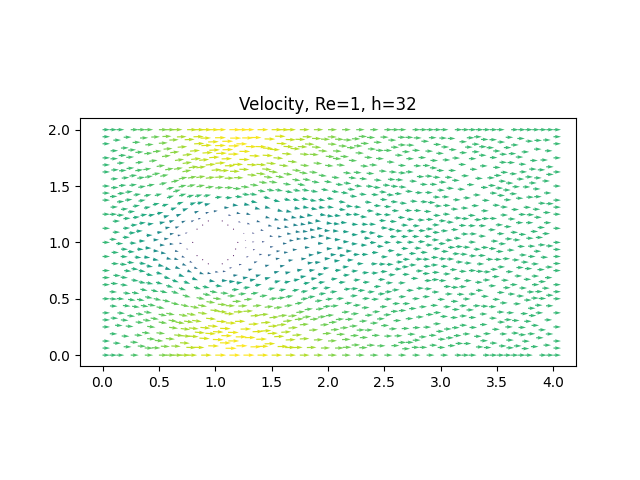

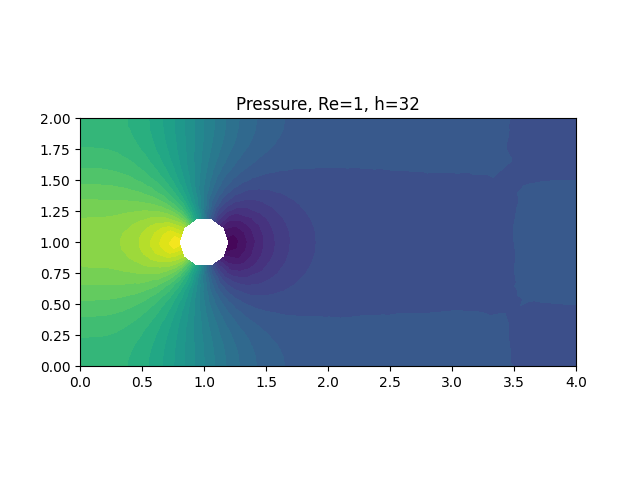

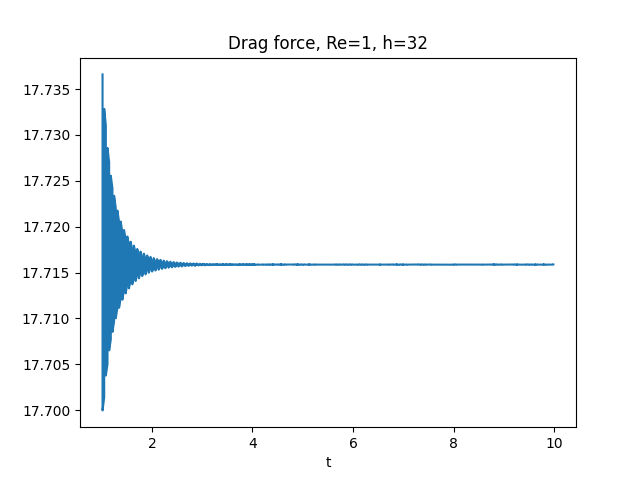

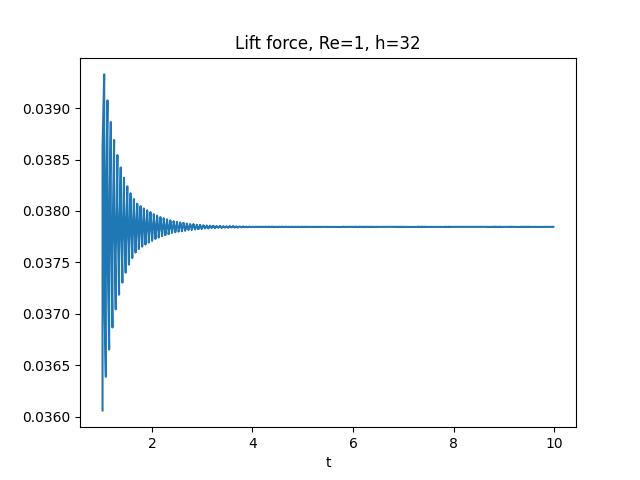

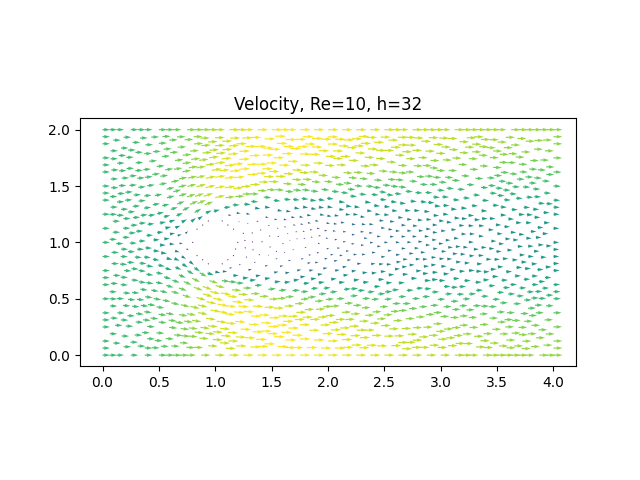

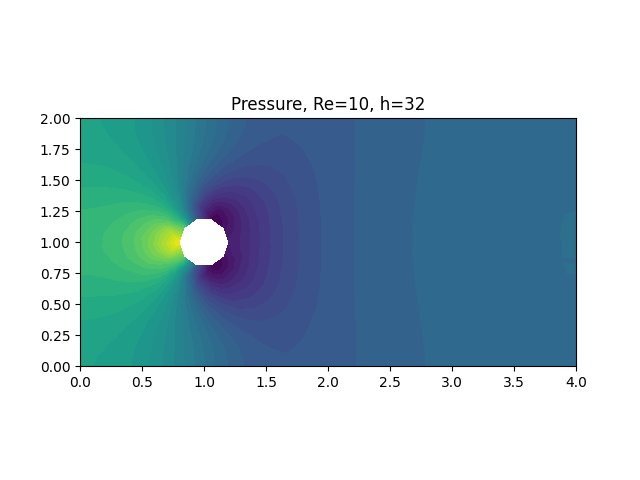

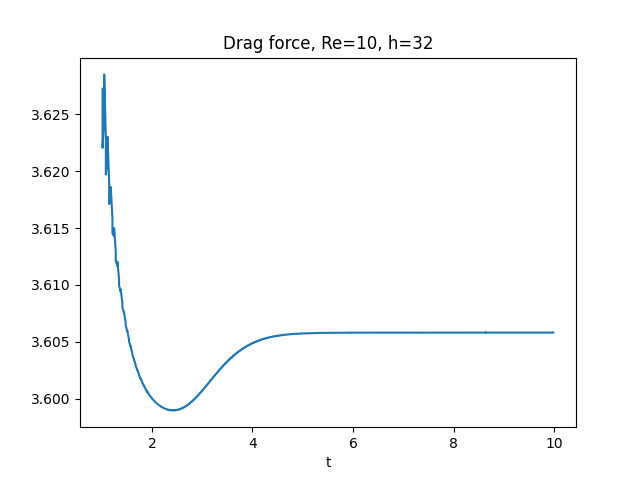

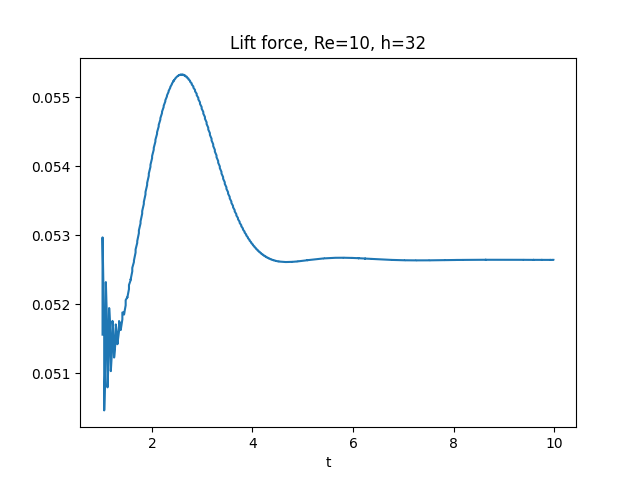

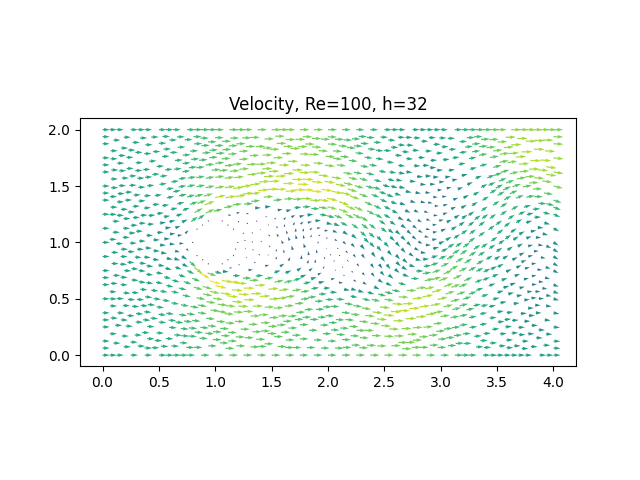

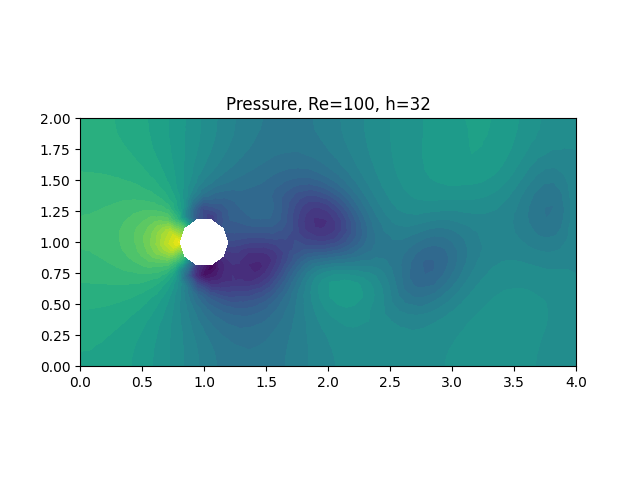

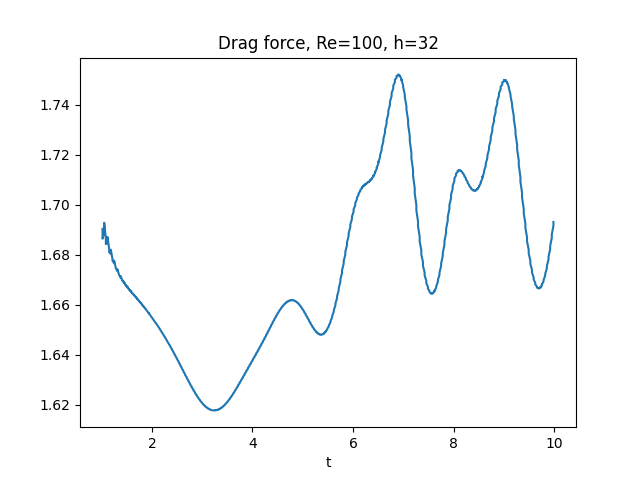

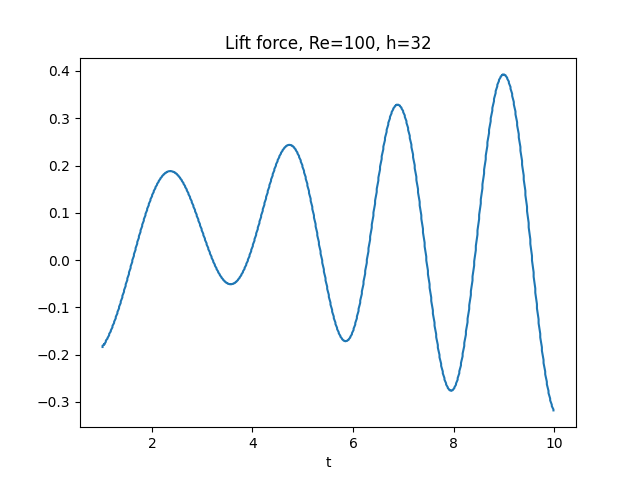

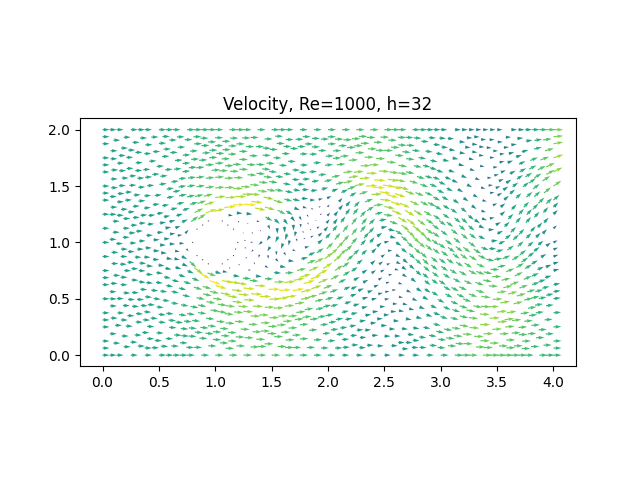

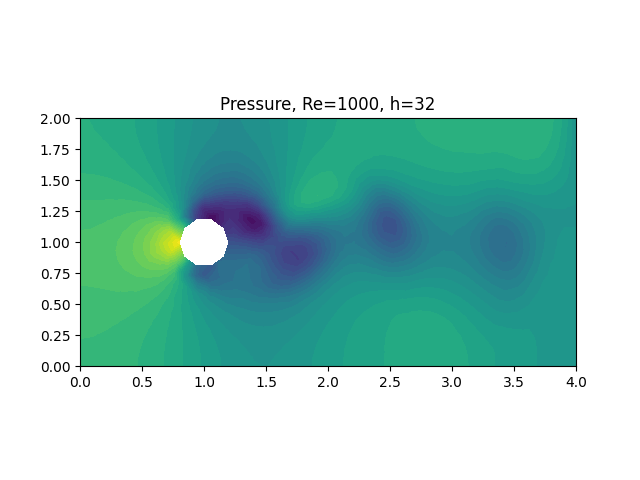

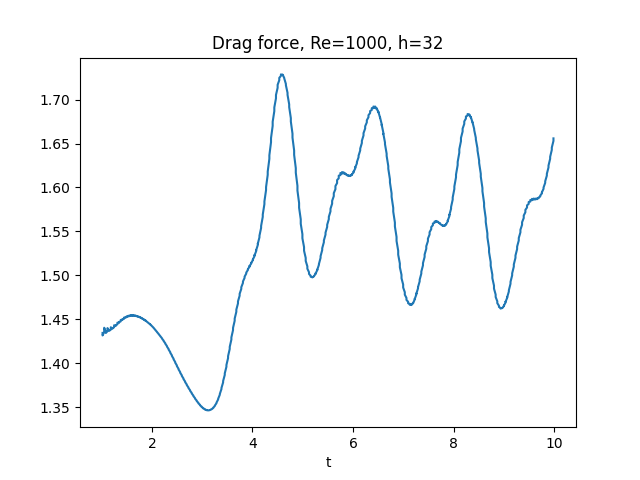

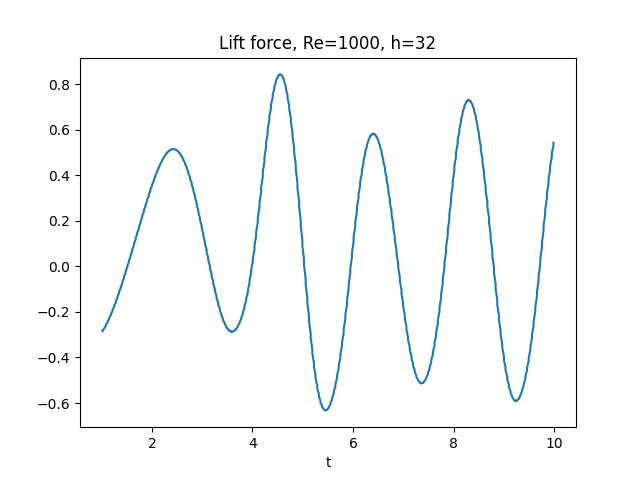

In [38]:
for Re in [1, 10, 100, 1000]:
    display(Image(f"Velocity, Re={Re}, h=32.png"))
    display(Image(f"Pressure, Re={Re}, h=32.png"))
    display(Image(f"Drag force, Re={Re}, h=32.png"))
    display(Image(f"Lift force, Re={Re}, h=32.png"))


**Plot results when changing mesh resolution for Re=100**

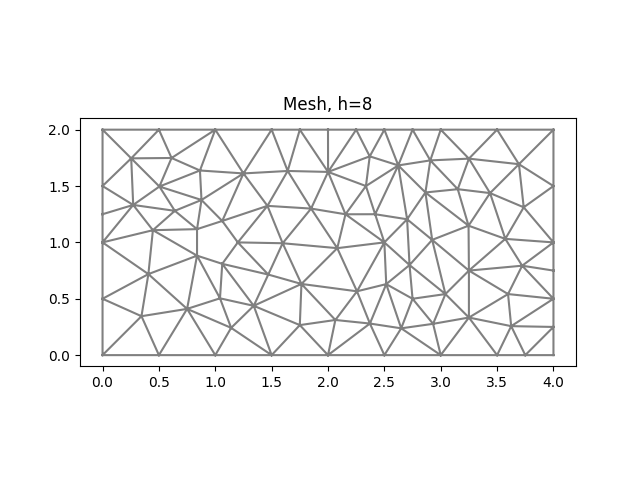

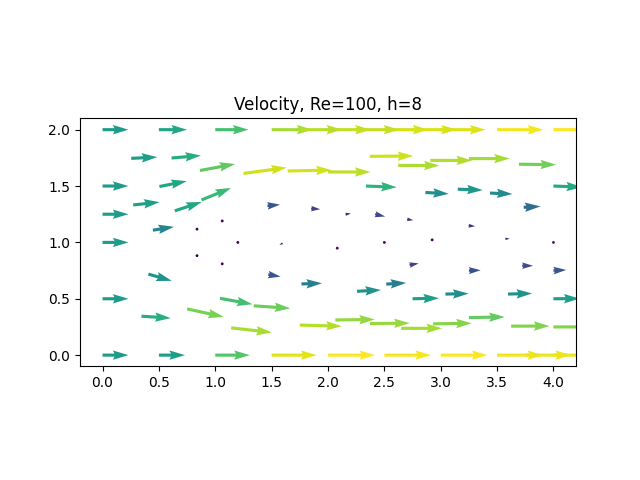

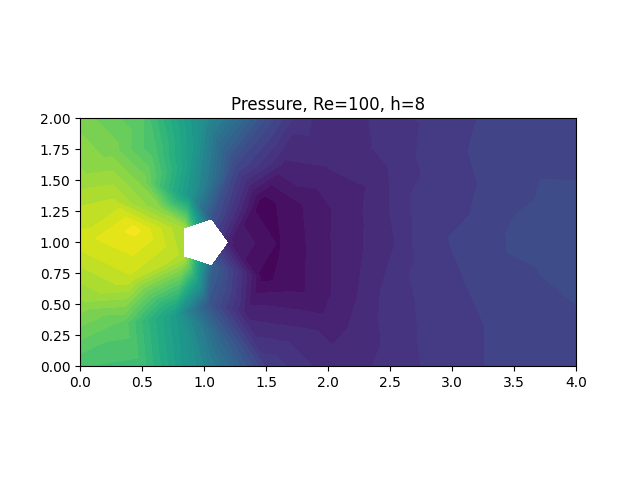

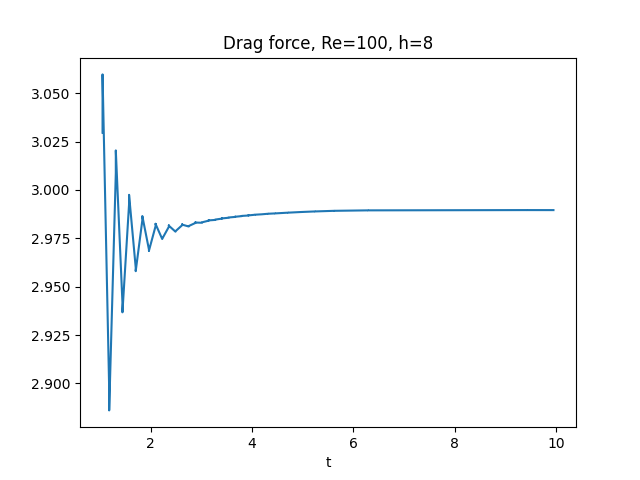

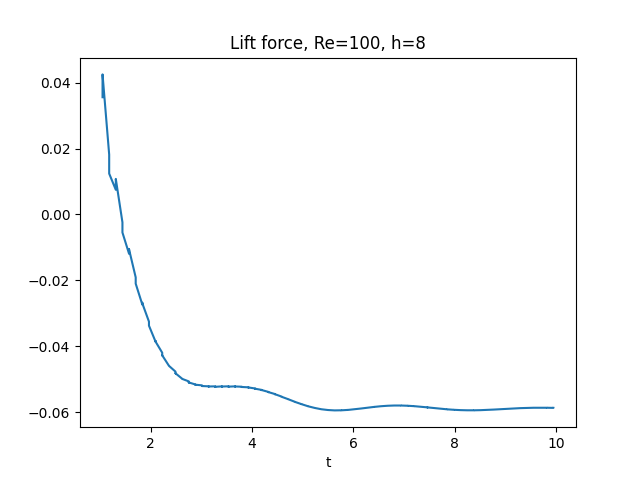

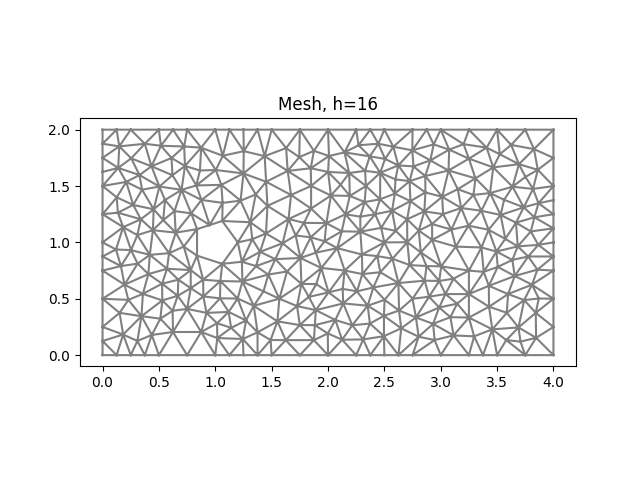

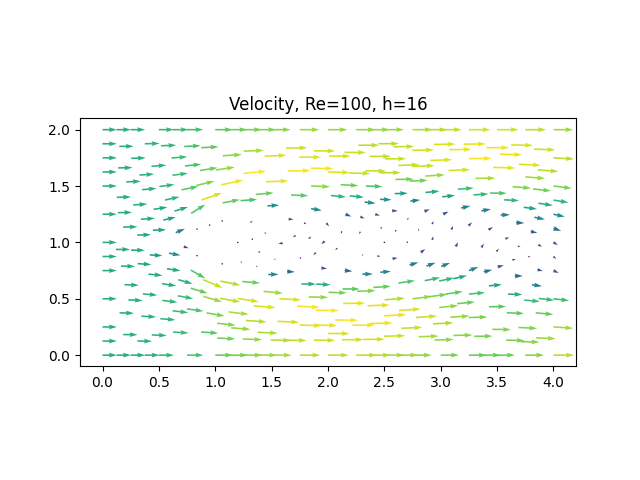

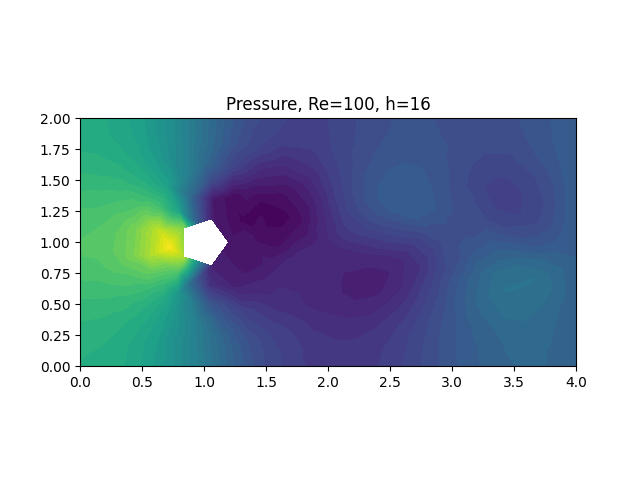

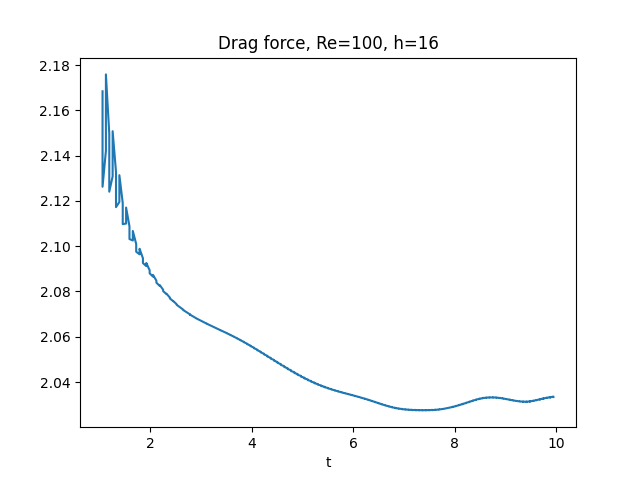

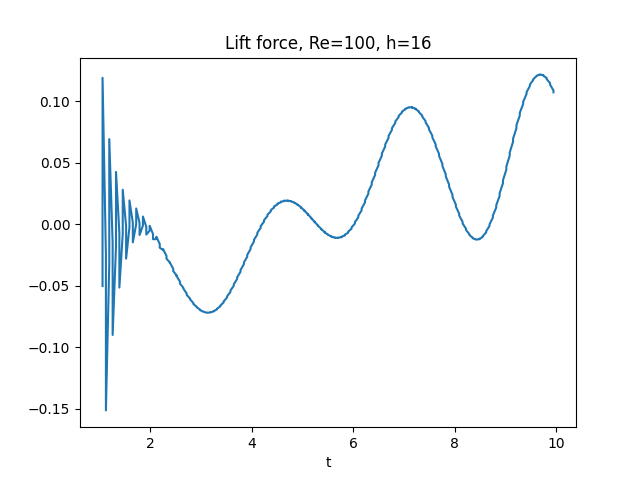

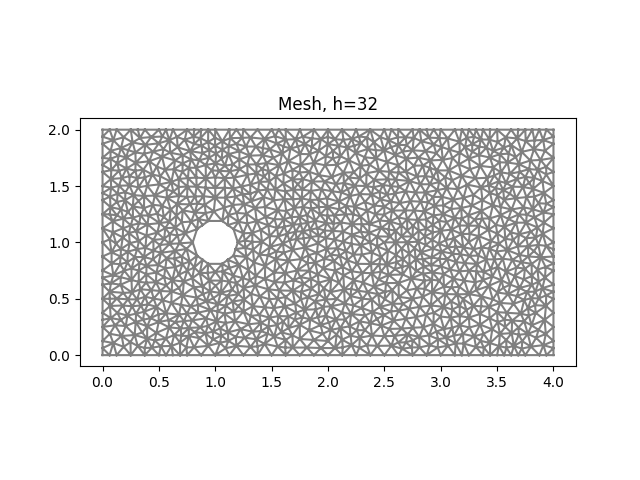

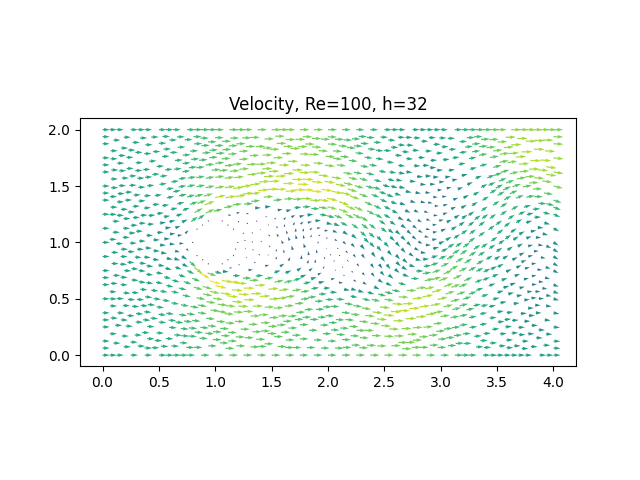

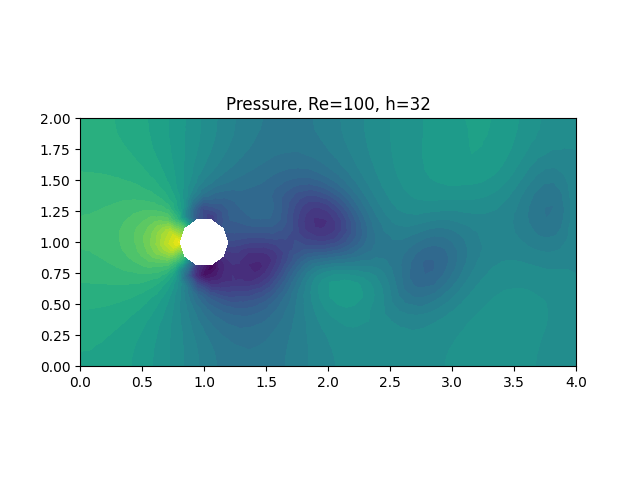

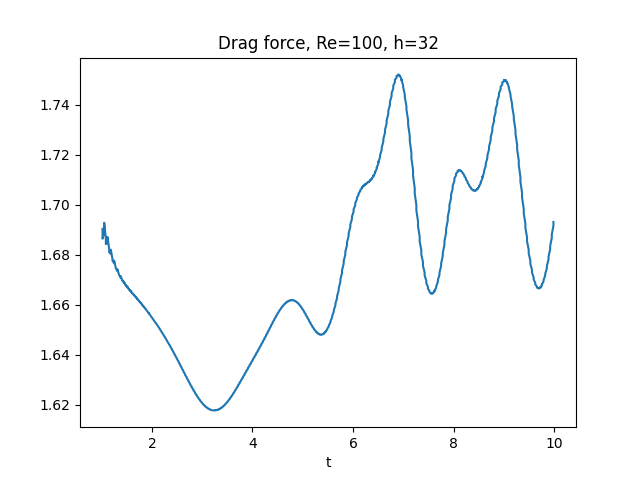

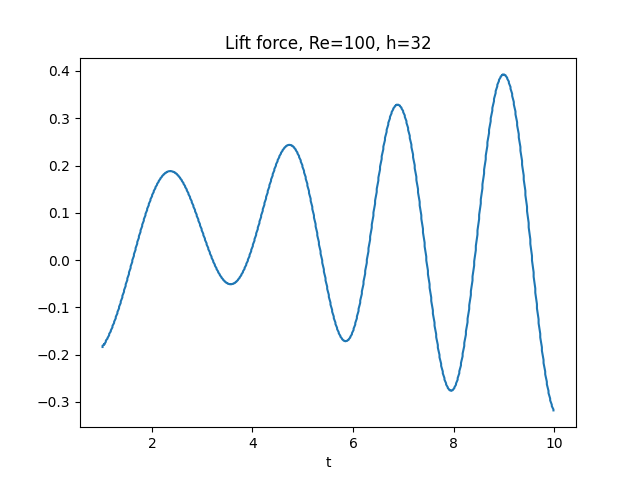

In [39]:
for h in [8, 16, 32]:
    display(Image(f"mesh, h={h}.png"))
    display(Image(f"Velocity, Re=100, h={h}.png"))
    display(Image(f"Pressure, Re=100, h={h}.png"))
    display(Image(f"Drag force, Re=100, h={h}.png"))
    display(Image(f"Lift force, Re=100, h={h}.png"))

**Drag and lift coefficients**

The drag coefficient $c_d$ is defined as
$$c_d = \frac{2 F_d}{\rho u^2 A}$$


The lift coefficient $c_l$ is defined in the same way as the drag coefficient, but for the lift force:
$$c_l = \frac{2 F_l}{\rho u^2 A}$$



Where $F_d$ is the drag force, which is the force component in the direction of the flow velocity, so in this case $F_d = \phi(1, 0)$ as previously mentioned.

$F_l$ is the lift force, which is the force component in the upward direct $\phi(1,0)$.

$\rho$ is the mass density of the fluid, which is equal to $1.0$ for this simulation.

$u$ is the flow speed of the object relative to the fluid, which is equal to $1.0$ for this simulation.

$A$ is the reference area of the object, which for this simulation is the circle from its side, projected downstream. Since the radius is 0.2 the projected area will be a rectangle with a height of 0.4 (and no width since the simulation is in 2D so the reference object's area is in 1D).

So, to calculate the drag and lif coefficients we end up with
$$c_d = \frac{2 F_d}{0.4} = 5 F_d$$
$$c_l = \frac{2 F_l}{0.4} = 5 F_l$$

Since the drag and lift force oscillate for some of the simulations, the average force will be used in the calculation.

For $Re = 1$:
$$c_d \approx 5 * 17.7 = 88.5$$
$$c_l \approx 5 * 0.038 = 0.19$$

For $Re = 10$:
$$c_d \approx 5 * 3.6 = 18$$
$$c_l \approx 5 * 0.053 = 0.265$$

For $Re = 100$:
$$c_d \approx 5 * 1.7 = 8.5$$
$$c_l \approx 5 * 0.05 = 0.25$$

For $Re = 1000$:
$$c_d \approx 5 * 1.6 = 8$$
$$c_l \approx 5 * 0.05 = 0.25$$


**Strouhal number**

The Strouhal number is defined as $St = \frac{fD}{U}$ for this problem where $f$ is the frequency of vortex shedding, $D=0.4$ is the diameter of the cylinder and $U=1$ is the inflow velocity. For this problem the Strouhal number can thus be calculated as:
$$St = 0.4 f$$

By looking at the lift force graph we can approximate the frequency of the vortex shedding as having the same frequency as the oscillating lift force.  

For $Re = 1$: No vortex shedding


For $Re = 10$: No vortex shedding


For $Re = 100$:
$f \approx 0.5$ Since the period of the lift force is about 2 seconds. This gives $St = 0.4*0.5 = 0.2$

For $Re = 1000$:
$f \approx 0.5$ Since the period of the lift force is about 2 seconds. This gives $St = 0.4*0.5 = 0.2$


For higher Reynolds numbers we begin to see von Karman vortex streets in the simulations and for $Re = 100$ and $Re = 1000$ we have Strouhal numbers of about 0.2 which is what we wanted to verify was true as per the assignment.


**Mesh resolution**

With a mesh resultion of $h=32$ we get the results from which the drag and lift coefficients and the Strouhal numbers were calculated.

When the mesh size is changed to $h=16$ and $h=8$ the drag force plot started to look more and more stable, to the point where almost no oscillations were seen. This is probably due to the coarsness of the mesh not being able to pick upp on the small changes. The more stable drag forces for $h=8$ and $h=16$ were also much higher than for the average force of the plot for $h=32$ indicating that the drag coefficients became larger the smaller $h$ became.

The same goes for the lift force plots where for $h=16$ we still had oscillations with a frequency of around 0.5 but for $h=8$ the graph looks much more smoother, almost as if there are no oscillations and no vortex shedding. But the size of the force in this case got more dampened the smaller $h$ became which means a the lift coefficients became smaller the smaller $h$ became. For $h=16$ the oscillation could still be clearly be seen and the Strouhal number is thus the same at 0.2. However, for $h=8$ the oscillations were almost non existant which makes the calculation of the Strouhal number not possible.

**Paraview visualization**

The simulation performed for Reynolds number = 100 and mesh resolution = 32 was exported and with the help of the open source software Paraview, an animation of the flow was created. If the video is not playing you can access it on my
[Google Drive](https://drive.google.com/file/d/1-6ztIREtHUMi2I5egaJgLTrbP3n1-pY_/view?usp=sharing).

In [40]:
url = "lab2_Re_100.mp4"
display(Video(url))

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)

As we can see from the results, the flow is steady for Reynolds numbers 1 and 10, and unsteady for 100 and 1000.